In [17]:
import matplotlib
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import svd
from scipy.linalg import pinv
import import_ipynb
import seaborn as sns
from sklearn.decomposition import PCA


In [2]:
data = np.genfromtxt('Data_Cortex_Nuclear.csv',delimiter=',',
                     skip_header=1,usecols=range(1,78),filling_values=0)
classes = np.genfromtxt('Data_Cortex_Nuclear.csv',delimiter=',',
                        skip_header=1,usecols=range(78,81),dtype=None)

data_pd = pd.read_csv("Data_Cortex_Nuclear.csv")

target_idx_A = np.where((classes[:,-1]==b'S/C') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Control'))[0]
target_idx_B = np.where((classes[:,-1]==b'S/C') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Ts65Dn'))[0]

labels = len(target_idx_A)*[0] + len(target_idx_B)*[1]
target_idx = np.concatenate((target_idx_A,target_idx_B))                                                                          

target = data[target_idx]

background_idx = np.where((classes[:,-1]==b'C/S') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Control'))
background = data[background_idx]

C:\Users\Eric\AppData\Local\Temp\ipykernel_15856\2104346160.py:3: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  classes = np.genfromtxt('Data_Cortex_Nuclear.csv',delimiter=',',


In [3]:
X = target
Y = background
union = np.concatenate((X,Y))
foreground_gene_names = data_pd.columns.values[1:-4]

In [4]:
os.chdir('C:/Users/Eric/OneDrive - University of North Carolina at Chapel Hill/dissertation work/project 2 - contrastive cur')
from main import*

In [5]:
k = 7
c = 10
cols_contrastive = ccur(X,Y, k, c)[0]
foreground_gene_names[cols_contrastive]

array(['SOD1_N', 'AcetylH3K9_N', 'Tau_N', 'Bcatenin_N', 'MTOR_N',
       'pCFOS_N', 'P38_N', 'IL1B_N', 'SHH_N', 'pS6_N'], dtype=object)

In [7]:
cols_foreground = deterministic_cur(X, k, c)[3]
foreground_gene_names[cols_foreground]

array(['Bcatenin_N', 'pCAMKII_N', 'pELK_N', 'pPKCG_N', 'NR2A_N',
       'PSD95_N', 'ERK_N', 'AcetylH3K9_N', 'pCASP9_N', 'NR1_N'],
      dtype=object)

In [8]:
orig_indicies = deterministic_cur(np.concatenate((X,Y)), k, c)[3]
foreground_gene_names[orig_indicies]

array(['pCAMKII_N', 'Bcatenin_N', 'pPKCG_N', 'pELK_N', 'NR2A_N',
       'pPKCAB_N', 'ELK_N', 'PSD95_N', 'ERK_N', 'pERK_N'], dtype=object)

In [19]:
alpha = 1
constrastive_cov = np.cov(X, rowvar = False) - alpha * np.cov(Y, rowvar = False)
eigenvalues, eigenvectors = np.linalg.eig(constrastive_cov)

first_pc = eigenvectors[:, np.argmax(eigenvalues)]  
top_indices = np.argsort(np.abs(first_pc))[-c:] 
foreground_gene_names[top_indices]  

array(['pMTOR_N', 'GSK3B_N', 'Bcatenin_N', 'pNR2B_N', 'pPKCG_N', 'NR1_N',
       'ERK_N', 'pPKCAB_N', 'NR2A_N', 'pCAMKII_N'], dtype=object)

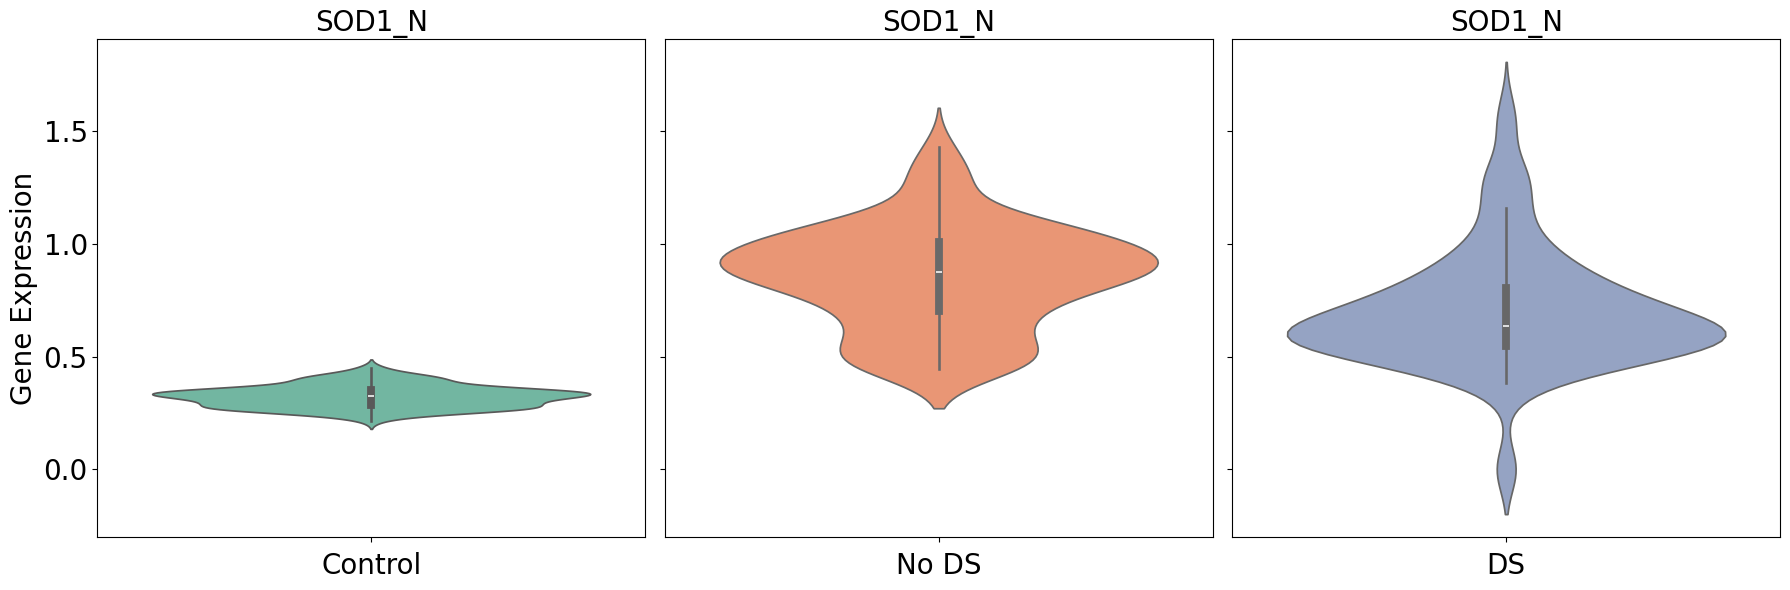

In [10]:
#gene_index = data_pd.columns.get_loc("MEK_N") - 1 
gene_index = cols_contrastive[0]  

gene_expression_foreground = target[:, gene_index]
gene_expression_background = background[:, gene_index]

data_foreground = pd.DataFrame({
    'Gene Expression': gene_expression_foreground,
    'Group': labels  # 0 or 1 for no Down syndrome or Down syndrome
})

data_background = pd.DataFrame({
    'Gene Expression': gene_expression_background,
    'Group': ['Control'] * len(gene_expression_background)  # Label as 'Control'
})

data_combined = pd.concat([data_foreground, data_background], ignore_index=True)
data_no_down_syndrome = data_foreground[data_foreground['Group'] == 0]
data_down_syndrome = data_foreground[data_foreground['Group'] == 1]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.violinplot(y='Gene Expression', data=data_background, ax=axes[0], color=sns.color_palette('Set2')[0])
axes[0].set_title(f"{foreground_gene_names[gene_index]}", fontsize=20)
axes[0].set_xlabel('Control', fontsize=20)
axes[0].set_ylabel('Gene Expression', fontsize=20)
axes[0].tick_params(axis='y', labelsize=20)

sns.violinplot(y='Gene Expression', data=data_no_down_syndrome, ax=axes[1], color=sns.color_palette('Set2')[1])
axes[1].set_title(f"{foreground_gene_names[gene_index]}", fontsize=20)
axes[1].set_xlabel('No DS', fontsize=20)
axes[1].set_xticklabels([])
axes[1].tick_params(axis='y', labelsize=20)

sns.violinplot(y='Gene Expression', data=data_down_syndrome, ax=axes[2], color=sns.color_palette('Set2')[2])
axes[2].set_title(f"{foreground_gene_names[gene_index]}", fontsize=20)
axes[2].set_xlabel('DS', fontsize=20)
axes[2].set_xticklabels([])
axes[2].tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.show()


In [22]:
k = 7
top_rows = 20
rows_contrastive = deterministic_cur(X[:,cols_contrastive],k,top_rows)[4]
rows_foreground = deterministic_cur(X,k, top_rows)[4]

In [23]:
labels = np.array(labels)

def calculate_proportion(rows, labels):
    """
    Calculate the proportion of 0 and 1 in the selected rows based on the labels array.
    """
    selected_labels = labels[rows]
    total = len(selected_labels)
    count_0 = np.sum(selected_labels == 0)
    count_1 = np.sum(selected_labels == 1)
    proportion_0 = count_0 / total
    proportion_1 = count_1 / total
    return count_0, count_1, proportion_0, proportion_1

count_0_contrastive, count_1_contrastive, prop_0_contrastive, prop_1_contrastive = calculate_proportion(rows_contrastive, labels)
count_0_foreground, count_1_foreground, prop_0_foreground, prop_1_foreground = calculate_proportion(rows_foreground, labels)

total_0 = np.sum(labels == 0)
total_1 = np.sum(labels == 1)
total = len(labels)
total_prop_0 = total_0 / total
total_prop_1 = total_1 / total

print("Proportion in rows_contrastive:")
print(f"Count 0: {count_0_contrastive}, Count 1: {count_1_contrastive}, Proportion 0: {prop_0_contrastive:.2f}, Proportion 1: {prop_1_contrastive:.2f}")

print("\nProportion in rows_foreground:")
print(f"Count 0: {count_0_foreground}, Count 1: {count_1_foreground}, Proportion 0: {prop_0_foreground:.2f}, Proportion 1: {prop_1_foreground:.2f}")

print("\nTotal counts and proportions across all labels:")
print(f"Total Count 0: {total_0}, Total Count 1: {total_1}, Total Proportion 0: {total_prop_0:.2f}, Total Proportion 1: {total_prop_1:.2f}")


Proportion in rows_contrastive:
Count 0: 12, Count 1: 8, Proportion 0: 0.60, Proportion 1: 0.40

Proportion in rows_foreground:
Count 0: 17, Count 1: 3, Proportion 0: 0.85, Proportion 1: 0.15

Total counts and proportions across all labels:
Total Count 0: 135, Total Count 1: 135, Total Proportion 0: 0.50, Total Proportion 1: 0.50


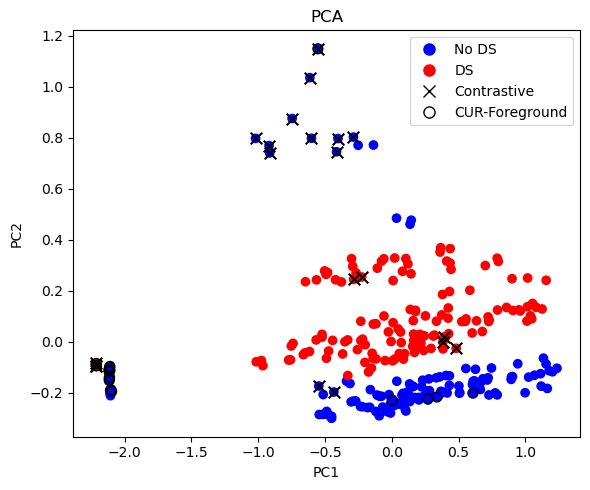

In [18]:
X_t = X[:, cols_contrastive]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_t)

numeric_labels = np.array(labels)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=numeric_labels, cmap='bwr')

plt.scatter(X_pca[rows_contrastive, 0], X_pca[rows_contrastive, 1], 
            color='black', marker='x', s=70, label='Contrastive')

plt.scatter(X_pca[rows_foreground, 0], X_pca[rows_foreground, 1], 
            facecolors='none', edgecolors='black', marker='o', s=50, label='CUR-Foreground')

legend_labels = ['No DS', 'DS']
handles = [
    plt.Line2D([0], [0], marker='o', color='blue', linestyle='None', markersize=8, label=legend_labels[0]),
    plt.Line2D([0], [0], marker='o', color='red', linestyle='None', markersize=8, label=legend_labels[1]),
    plt.Line2D([0], [0], marker='x', color='black', linestyle='None', markersize=8, label='Contrastive'),
    plt.Line2D([0], [0], marker='o', color='black', markerfacecolor='none', linestyle='None', markersize=8, label='CUR-Foreground')
]

plt.legend(handles=handles, loc='upper right')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA')
plt.tight_layout()
plt.show()
